# Project

Author: Billy Shi, Zach Fong

## Data Preprocessing

### join_split_data

Join and split the data in to raw form

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import desc, col, max, when, sum
from pyspark.sql import SparkSession, functions, types, Row

# Adjustable params
train_set_precentage = 0.9
invalid_info = ["[deleted]", "[removed]"]

    
spark = SparkSession.builder \
    .appName("Join and split data") \
    .getOrCreate()
# Getting raw data
post_df = spark.read.json("./askreddit/submissions/")
comment_df = spark.read.json("./askreddit/comments/")

# Filter out null rows and invalid rows
valid_post = post_df.filter(~col('title').isin(invalid_info) & col('name').isNotNull())
valid_comment = comment_df.filter((~col('body').isin(invalid_info)))
valid_comment = valid_comment.withColumnRenamed("score", "comment_score")\
    .withColumnRenamed("ups", "comment_ups").withColumnRenamed("id", "comment_id")

# Top 1000 posts
top_posts = valid_post.orderBy(desc("score")).limit(1000)

# Train, test split
test_set_precentage = 1 - train_set_precentage
split_df = top_posts.randomSplit([test_set_precentage, train_set_precentage])

test_set = split_df[0]
train_set = split_df[1]

# Renaming columns
train_set = train_set.withColumnRenamed("score", "post_score").withColumnRenamed("ups", "post_ups")\
    .withColumnRenamed("id", "post_id")
# Join the post with comments
joined_train = train_set.join(valid_comment, valid_comment['parent_id'] == train_set['name'], "inner")
# Compute the max score among the post for each comment
max_comment_score_train = joined_train.groupBy(col("parent_id")). \
    agg(max("comment_score").alias("max_comment_score"))
joined_train = joined_train.join(max_comment_score_train, "parent_id", "left")
# Select the columns to be saved
selected_columns_train = joined_train.select("post_id", "comment_id", "title", "selftext", "body", "comment_score", "post_score", "max_comment_score", "comment_ups", "post_ups", "controversiality", "num_comments")

## Repeat for test set
# Renaming columns
test_set = test_set.withColumnRenamed("score", "post_score").withColumnRenamed("ups", "post_ups")\
    .withColumnRenamed("id", "post_id")
# Join the post with comments
joined_test = test_set.join(valid_comment, valid_comment['parent_id'] == test_set['name'], "inner")
# Compute the max score among the post for each comment
max_comment_score_test = joined_test.groupBy(col("parent_id")). \
    agg(max("comment_score").alias("max_comment_score"))
joined_test = joined_test.join(max_comment_score_test, "parent_id", "left")
# Select the columns to be saved
selected_columns_test = joined_test.select("post_id", "comment_id", "title", "selftext", "body", "comment_score", "post_score", "max_comment_score", "comment_ups", "post_ups", "controversiality", "num_comments")

selected_columns_train.write \
    .option("compression", "snappy") \
    .parquet("./data/joined_train_raw", mode="overwrite")

selected_columns_test.write \
    .option("compression", "snappy") \
    .parquet("./data/joined_test_raw", mode="overwrite")

### Optional: join_save_data

To save extra raw data sets if needed, in the below case, we get top 1000-1100 post as our out of domain test set.

In [ ]:
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import desc, col, max, when, sum, row_number
from pyspark.sql import SparkSession, functions, types, Row

invalid_info = ["[deleted]", "[removed]"]
file_save_path = "./data/joined_test_extra_raw"

    
spark = SparkSession.builder \
    .appName("Join and split data") \
    .getOrCreate()
# Getting raw data
post_df = spark.read.json("./askreddit/submissions/")
comment_df = spark.read.json("./askreddit/comments/")

# Filter out null rows and invalid rows
valid_post = post_df.filter(~col('title').isin(invalid_info) & col('name').isNotNull())
valid_comment = comment_df.filter((~col('body').isin(invalid_info)))
valid_comment = valid_comment.withColumnRenamed("score", "comment_score")\
    .withColumnRenamed("ups", "comment_ups").withColumnRenamed("id", "comment_id")

# Define the window specification with ordering
windowSpec = Window.orderBy(desc("score"))
# Add a row number to each row
ranked_posts = valid_post.withColumn("row_number", row_number().over(windowSpec))
# Filter to get rows 1001 to 1100
top_posts = ranked_posts.where((ranked_posts.row_number >= 1001) & (ranked_posts.row_number <= 1100))
# Optionally, you can drop the row_number column if you don't need it
top_posts = top_posts.drop("row_number")

# Renaming columns
top_posts = top_posts.withColumnRenamed("score", "post_score").withColumnRenamed("ups", "post_ups")\
    .withColumnRenamed("id", "post_id")
# Join the post with comments
joined = top_posts.join(valid_comment, valid_comment['parent_id'] == top_posts['name'], "inner")
# Compute the max score among the post for each comment
max_comment_score_train = joined.groupBy(col("parent_id")). \
    agg(max("comment_score").alias("max_comment_score"))
joined = joined.join(max_comment_score_train, "parent_id", "left")
# Select the columns to be saved
selected_columns = joined.select("post_id", "comment_id", "title", "selftext", "body", "comment_score", "post_score", "max_comment_score", "comment_ups", "post_ups", "controversiality", "num_comments")


selected_columns.write \
    .option("compression", "snappy") \
    .parquet(file_save_path, mode="overwrite")


### process_raw_data

Process the raw data into clean data

In [ ]:
from pyspark.sql import SparkSession, types, functions, Window
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import pandas as pd

def processData(df):
    df = df.withColumnRenamed("body", "comment").withColumnRenamed("selftext", "post_body")
    null_comments = ["[deleted]", "[removed]"]
    cleaned_df = df.filter(~F.col("comment").isin(null_comments))
    cleaned_df = cleaned_df.filter((F.col("post_body").isNull()) | (F.trim(F.col("post_body")) == ""))

    cleaned_df = cleaned_df.withColumn("comment_score_ratio", F.col("comment_score")/F.col("max_comment_score"))

    # Get rid of duplicate comments
    window_spec = Window.partitionBy('post_id', 'comment').orderBy(F.col('comment_score').desc())
    without_dupes = cleaned_df.withColumn('row_number', F.row_number().over(window_spec))
    without_dupes = without_dupes.filter(F.col('row_number') == 1)
    without_dupes = without_dupes.drop('row_number')
    cleaned_df = without_dupes
    unwanted_columns = ["post_id", "comment_id", "post_body", "post_score", "max_comment_score", "post_ups", "controversiality", "num_comments"]
    cleaned_df = cleaned_df.drop(*unwanted_columns)

    return cleaned_df

In [ ]:
spark = SparkSession.builder \
    .appName("askreddit data process") \
    .getOrCreate()

train_set_raw = spark.read.parquet("./data/joined_train_raw")
test_set_raw = spark.read.parquet("./data/joined_test_raw")

train_set_cleaned = processData(train_set_raw)
test_set_cleaned = processData(test_set_raw)

train_set_cleaned.write.parquet("./data/joined_train_clean", mode="overwrite")
test_set_cleaned.write.parquet("./data/joined_test_clean", mode="overwrite")

## Compute embeddings and other metrics

This is to freeze the BERT model, so we pre-compute the embeddings for each comment pair, thus allows a much faster tuning and trials for the regression head

### Compute and save embeddings - save_embeddings

In [ ]:
import torch
import tqdm
from transformers import AutoTokenizer, AutoModel

import numpy as np
import pandas as pd

import h5py
import gc

# Nvidia cuda
device_avaliable = 'cuda' if torch.cuda.is_available() else 'cpu'
# Apple Metal
device_avaliable = 'mps' if torch.backends.mps.is_available() else device_avaliable
device = torch.device(device_avaliable)

# HP:
current_group = 'test' # test or train
model_name = 'distilbert-base-uncased'
target_column = 'comment_score_ratio'

src_path = f'./data/joined_{current_group}_clean/'
save_path = f'./data/embeddings_{current_group}.h5'

target_save_path = f'./data/target_{current_group}.npy'

In [ ]:
def tokenize_comments_batch(titles, comments, tokenizer, max_length=512):
    """
    Tokenize a batch of title-comment pairs.
    """
    
    # Tokenize the batch
    encoded_batch = tokenizer(titles, comments,
                              padding=True,
                              truncation=True,
                              max_length=max_length,
                              return_tensors='pt')
    return encoded_batch


def get_embeddings(encoded_inputs, model):
    """
    Get embeddings for a batch of tokenized inputs.
    """
    with torch.no_grad():
        outputs = model(**encoded_inputs)
        hidden_states = outputs.last_hidden_state
    embeddings = torch.mean(hidden_states, dim=1)
    return embeddings

def tokenize_and_get_embeddings_save(titles, comments, ids, target_scores, tokenizer, model, batch_size=32):
    """
    Process a list of titles and comments to get their embeddings in batches.
    """
    # Ensure titles and comments are lists of the same length
    assert len(titles) == len(comments), "Titles and comments must be lists of the same length."
    print("Computing embeddings and saving")
    # Prepare for batching
    total = len(titles)
    with h5py.File(save_path, 'w') as f:
        # Initialize the dataset within the HDF5 file      # embedding size: 768, other 3 columns: id, length, target_score
        embeddings_dataset = f.create_dataset('embeddings', shape=(total, 768+3), dtype='float32', compression='gzip', compression_opts=9)
        
        
        for start_idx in tqdm.tqdm(range(0, total, batch_size)):
            end_idx = start_idx + batch_size
            batch_titles = titles[start_idx:end_idx]
            batch_comments = comments[start_idx:end_idx]
            
            # Tokenize the batch
            encoded_batch = tokenize_comments_batch(batch_titles, batch_comments, tokenizer, max_length=512)
            
            # Move encoded inputs to GPU
            encoded_batch = {k: v.to(model.device) for k, v in encoded_batch.items()}
            
            # Get embeddings
            batch_embeddings = get_embeddings(encoded_batch, model)
            
            # Write the batch embeddings directly to the HDF5 dataset
            embeddings_dataset[start_idx:end_idx, 0:768] = batch_embeddings.cpu().numpy()
        
            # Clean up to prevent memory leak
            del batch_embeddings
            del encoded_batch
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache() 
            elif torch.backends.mps.is_available():
                torch.mps.empty_cache()

        print("Saving addtional columns")
        
        all_ids = np.array(ids)
        all_lengths = np.array([len(comment) for comment in comments])
        all_scores = np.array(target_scores)
        # Append additional data after embeddings are all computed
        embeddings_dataset[:, 768] = all_ids
        embeddings_dataset[:, 769] = all_lengths
        embeddings_dataset[:, 770] = all_scores

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model = model.to(device)

df = pd.read_parquet(src_path)

# Test
# df = df.iloc[0:1000]

print("Data size:", df.shape[0])

# print("Saving targets")
# np.save(target_save_path, df[target_column].values)

titles = df['title'].tolist()
comments = df['comment'].tolist()

# Additional columns
# USE INDEX FOR NOW
ids = df.index.to_list()
target_scores = df['comment_score_ratio'].to_numpy()


# Tokenize, compute the embeddings and save as h5py
tokenize_and_get_embeddings_save(titles, comments, ids, target_scores, tokenizer, model, batch_size=32)

In [ ]:
# Addtionally we compute and save the tokenized lengths
tokenized_input = tokenizer(titles, comments,
                padding=False,
                truncation=False,
                max_length=None,
                return_length=True,
                return_tensors='np')
tokenized_input_len = tokenized_input['length']
print(tokenized_input_len.max())

tokenized_title = tokenizer(titles,
                padding=False,
                truncation=False,
                max_length=None,
                return_length=True,
                return_tensors='np')
tokenized_title_len = tokenized_title['length']
print(tokenized_title_len.max())

tokenized_comment = tokenizer(comments,
                padding=False,
                truncation=False,
                max_length=None,
                return_length=True,
                return_tensors='np')
tokenized_comment_len = tokenized_comment['length']
print(tokenized_comment_len.max())

assert tokenized_comment_len.shape == tokenized_title_len.shape == tokenized_input_len.shape

In [ ]:
# Save the computed tokenized lengths and target
tokenize_lengths_with_score = pd.DataFrame({'tokenized_input_len': tokenized_input_len, 'tokenized_title_len': tokenized_title_len,\
                    'tokenized_comment_len': tokenized_comment_len, 'target_scores' : target_scores})


tokenize_lengths_with_score.to_parquet("./data/test_tokenize_lengths_with_score.parquet", index=False, compression='gzip')
tokenize_lengths_with_score =  pd.read_parquet("./data/test_tokenize_lengths_with_score.parquet")

tokenize_lengths_with_score.head(10)

## Train 

### Training Process - train

In [5]:
import argparse, os, string, sys
import torch
from tqdm import tqdm
from pathlib import Path
from transformers import BertModel, AutoTokenizer
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np

import pdb

import h5py
# import peft

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Nvidia cuda
device_avaliable = 'cuda' if torch.cuda.is_available() else 'cpu'
# # Apple Metal
# device_avaliable = 'mps' if torch.backends.mps.is_available() else device_avaliable
device = torch.device(device_avaliable)

basemodel = 'distilbert-base-uncased'

epochs = 8

batch_size = 64

# path_to_model = '../data/models/regression_head_MLP.pth'
path_to_model = 'regression_head.pth'

load_model = True

In [2]:
class EmbeddingsDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = embeddings
        self.targets = targets
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        target = self.targets[idx]
        embedding_pt = torch.tensor(embedding, dtype=torch.float)
        target_pt = torch.tensor(target, dtype=torch.float)
        return {
            'embeddings' : embedding_pt, 
            'targets' : target_pt
        }
    
# class RegressionHead(nn.Module):
#     def __init__(self, hidden_layer_size):
#         super(RegressionHead, self).__init__()
#         self.out = nn.Linear(hidden_layer_size, 1)

#     def forward(self, embeddings):
#         return self.out(embeddings)

class RegressionHead(torch.nn.Module):
    def __init__(self, hidden_layer_size):
        super(RegressionHead, self).__init__()

        self.regression_head = nn.Sequential(
            nn.Linear(hidden_layer_size, 512),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.regression_head(x)

In [3]:
# Load the train data of embeddings and targets
with h5py.File('../data/embeddings_train.h5', 'r') as f:
    embeddings_np = f['embeddings'][:]
    print(embeddings_np.shape)

targets_np = np.load('../data/target_train.npy')

assert len(targets_np) == len(embeddings_np)

# Load the test data of embeddings and targets
with h5py.File('../data/embeddings_test.h5', 'r') as f:
    test_embeddings_np = f['embeddings'][:]
    print(test_embeddings_np.shape)

test_targets_np = np.load('../data/target_test.npy')

assert len(test_targets_np) == len(test_embeddings_np)

(1818842, 768)
(200210, 768)


In [6]:
dataset = EmbeddingsDataset(embeddings_np, targets_np)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset = EmbeddingsDataset(test_embeddings_np, test_targets_np)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

criterion = nn.MSELoss()

if os.path.exists(path_to_model) and load_model:
# if False:
    # Load the model
    regression_head = torch.load(path_to_model)
    regression_head.eval()  # Set the model to evaluation mode if you're only doing inference
    print("Model loaded successfully.")
    test_loss = 0
    with torch.no_grad():  # Disable gradient calculation
        for batch in test_dataloader:
            embeddings = batch['embeddings'].to(device)
            targets = batch['targets'].to(device)
            outputs = regression_head(embeddings)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
    test_loss /= len(test_dataloader)
    print(f"Test Loss: {test_loss}")
else:
    print("Creating new model.")
    hidden_layer_size = embeddings_np.shape[1]
    # regression_head = RegressionHead(hidden_layer_size, additional_hidden_sizes=[256], dropout_rate=0.1)
    regression_head = RegressionHead(hidden_layer_size)


Model loaded successfully.
Test Loss: 0.0022126934084872947


In [10]:
epochs = 500

regression_head = regression_head.to(device)

optimizer = optim.Adam(regression_head.parameters(), lr=1e-5)

# For stats
training_losses = []
test_losses = []

for epoch in range(epochs):
    regression_head.train()
    running_loss = 0.0
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        embeddings = batch['embeddings'].to(device)
        targets = batch['targets'].to(device)
        outputs = regression_head(embeddings)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(dataloader)
    training_losses.append(train_loss)
    print(f"Epoch {epoch+1}, Training Loss: {train_loss}")

    # Evaluate on test data
    regression_head.eval()  # Set the model to evaluation mode
    test_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for batch in test_dataloader:
            embeddings = batch['embeddings'].to(device)
            targets = batch['targets'].to(device)
            outputs = regression_head(embeddings)
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()
    test_loss /= len(test_dataloader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}, Test Loss: {test_loss}")
    # torch.save(regression_head, path_to_model + '_' + str(epoch))
    torch.save(regression_head, path_to_model)


100%|██████████| 28420/28420 [00:36<00:00, 787.40it/s] 


Epoch 1, Training Loss: 0.0023389708893916516
Epoch 1, Test Loss: 0.0021511704503390057


100%|██████████| 28420/28420 [00:37<00:00, 758.44it/s] 


Epoch 2, Training Loss: 0.0023263837661429126
Epoch 2, Test Loss: 0.0021123349650369306


100%|██████████| 28420/28420 [00:38<00:00, 736.31it/s] 


Epoch 3, Training Loss: 0.002319647473687241
Epoch 3, Test Loss: 0.0021434500560680125


100%|██████████| 28420/28420 [00:39<00:00, 711.27it/s]


Epoch 4, Training Loss: 0.002311435122984163
Epoch 4, Test Loss: 0.0021107662091651657


100%|██████████| 28420/28420 [00:33<00:00, 841.26it/s] 


Epoch 5, Training Loss: 0.002299499975743075
Epoch 5, Test Loss: 0.0021224304263469367


100%|██████████| 28420/28420 [00:38<00:00, 733.23it/s] 


Epoch 6, Training Loss: 0.0022916473482617146
Epoch 6, Test Loss: 0.0021155755447751505


100%|██████████| 28420/28420 [00:39<00:00, 728.24it/s] 


Epoch 7, Training Loss: 0.002282292333683633
Epoch 7, Test Loss: 0.002141893872063321


100%|██████████| 28420/28420 [00:39<00:00, 728.17it/s] 


Epoch 8, Training Loss: 0.0022744285435816777
Epoch 8, Test Loss: 0.0021555045966876406


100%|██████████| 28420/28420 [00:39<00:00, 710.50it/s] 


Epoch 9, Training Loss: 0.0022681861305544047
Epoch 9, Test Loss: 0.00211621499117444


100%|██████████| 28420/28420 [00:39<00:00, 723.50it/s] 


Epoch 10, Training Loss: 0.002257898769290832
Epoch 10, Test Loss: 0.0021341014270046784


100%|██████████| 28420/28420 [00:39<00:00, 726.72it/s] 


Epoch 11, Training Loss: 0.0022517358819350974
Epoch 11, Test Loss: 0.002232369401706188


100%|██████████| 28420/28420 [00:38<00:00, 737.14it/s] 


Epoch 12, Training Loss: 0.0022413866903064185
Epoch 12, Test Loss: 0.0021793567798949463


100%|██████████| 28420/28420 [00:37<00:00, 760.21it/s] 


Epoch 13, Training Loss: 0.00223376636790251
Epoch 13, Test Loss: 0.00216660329755054


100%|██████████| 28420/28420 [00:32<00:00, 872.97it/s] 


Epoch 14, Training Loss: 0.002227168486232356
Epoch 14, Test Loss: 0.0021909128958668444


100%|██████████| 28420/28420 [00:29<00:00, 950.56it/s] 


Epoch 15, Training Loss: 0.0022190343608539343
Epoch 15, Test Loss: 0.002200703248903791


100%|██████████| 28420/28420 [00:38<00:00, 731.23it/s]


Epoch 16, Training Loss: 0.0022134757006154536
Epoch 16, Test Loss: 0.0021441634372236676


100%|██████████| 28420/28420 [00:38<00:00, 738.23it/s] 


Epoch 17, Training Loss: 0.002207674808497992
Epoch 17, Test Loss: 0.0021674155021937517


100%|██████████| 28420/28420 [00:37<00:00, 759.38it/s] 


Epoch 18, Training Loss: 0.0021987515372360452
Epoch 18, Test Loss: 0.002189365963833765


100%|██████████| 28420/28420 [00:38<00:00, 745.62it/s] 


Epoch 19, Training Loss: 0.0021947508406056524
Epoch 19, Test Loss: 0.0021782769544949595


100%|██████████| 28420/28420 [00:38<00:00, 739.14it/s] 


Epoch 20, Training Loss: 0.0021903205130416625
Epoch 20, Test Loss: 0.0021771767623545804


100%|██████████| 28420/28420 [00:37<00:00, 761.45it/s] 


Epoch 21, Training Loss: 0.0021792735475614352
Epoch 21, Test Loss: 0.0021762486914833797


100%|██████████| 28420/28420 [00:37<00:00, 763.88it/s]


Epoch 22, Training Loss: 0.0021768846679319476
Epoch 22, Test Loss: 0.0021756143100833377


100%|██████████| 28420/28420 [00:35<00:00, 800.69it/s] 


Epoch 23, Training Loss: 0.0021665609110775295
Epoch 23, Test Loss: 0.002151723970387009


100%|██████████| 28420/28420 [00:38<00:00, 739.86it/s] 


Epoch 24, Training Loss: 0.0021618583439653874
Epoch 24, Test Loss: 0.0021447285333783686


100%|██████████| 28420/28420 [00:38<00:00, 742.81it/s] 


Epoch 25, Training Loss: 0.0021560000962162094
Epoch 25, Test Loss: 0.0022037720121887176


100%|██████████| 28420/28420 [00:38<00:00, 735.02it/s] 


Epoch 26, Training Loss: 0.002148255280441578
Epoch 26, Test Loss: 0.0021499573019333794


100%|██████████| 28420/28420 [00:36<00:00, 776.92it/s] 


Epoch 27, Training Loss: 0.002144599987792261
Epoch 27, Test Loss: 0.0021781243329677498


100%|██████████| 28420/28420 [00:37<00:00, 763.53it/s] 


Epoch 28, Training Loss: 0.0021359506265678503
Epoch 28, Test Loss: 0.002169377255809034


100%|██████████| 28420/28420 [00:38<00:00, 744.18it/s] 


Epoch 29, Training Loss: 0.002130060546468684
Epoch 29, Test Loss: 0.0022233489313118267


100%|██████████| 28420/28420 [00:35<00:00, 795.90it/s] 


Epoch 30, Training Loss: 0.002120956016072208
Epoch 30, Test Loss: 0.002300066195209467


100%|██████████| 28420/28420 [00:37<00:00, 758.20it/s] 


Epoch 31, Training Loss: 0.0021180155244028285
Epoch 31, Test Loss: 0.002191132157355598


100%|██████████| 28420/28420 [00:35<00:00, 799.61it/s] 


Epoch 32, Training Loss: 0.00210792668117357
Epoch 32, Test Loss: 0.0021901946479652187


100%|██████████| 28420/28420 [00:37<00:00, 760.53it/s]


Epoch 33, Training Loss: 0.002101384376383604
Epoch 33, Test Loss: 0.0021635447511907575


100%|██████████| 28420/28420 [00:38<00:00, 742.82it/s] 


Epoch 34, Training Loss: 0.002095273318399303
Epoch 34, Test Loss: 0.0021770022315444337


100%|██████████| 28420/28420 [00:37<00:00, 759.11it/s] 


Epoch 35, Training Loss: 0.0020832042372673693
Epoch 35, Test Loss: 0.002149835688395311


100%|██████████| 28420/28420 [00:35<00:00, 804.65it/s] 


Epoch 36, Training Loss: 0.00207932108403222
Epoch 36, Test Loss: 0.0021836528271384718


100%|██████████| 28420/28420 [00:35<00:00, 808.40it/s] 


Epoch 37, Training Loss: 0.0020709348400843076
Epoch 37, Test Loss: 0.002213289312224168


100%|██████████| 28420/28420 [00:33<00:00, 840.05it/s] 


Epoch 38, Training Loss: 0.00206011341272666
Epoch 38, Test Loss: 0.0022761019553088515


100%|██████████| 28420/28420 [00:31<00:00, 889.67it/s] 


Epoch 39, Training Loss: 0.0020556853111690174
Epoch 39, Test Loss: 0.00235345738817789


100%|██████████| 28420/28420 [00:38<00:00, 740.06it/s] 


Epoch 40, Training Loss: 0.0020431492358048537
Epoch 40, Test Loss: 0.002192363632722128


100%|██████████| 28420/28420 [00:35<00:00, 804.97it/s] 


Epoch 41, Training Loss: 0.0020362175483953308
Epoch 41, Test Loss: 0.0022073947281803985


100%|██████████| 28420/28420 [00:35<00:00, 807.53it/s] 


Epoch 42, Training Loss: 0.0020292338425312896
Epoch 42, Test Loss: 0.002317462976385169


100%|██████████| 28420/28420 [00:36<00:00, 776.27it/s] 


Epoch 43, Training Loss: 0.00201982808614741
Epoch 43, Test Loss: 0.0022860015469051012


100%|██████████| 28420/28420 [00:37<00:00, 762.90it/s] 


Epoch 44, Training Loss: 0.0020124925134257098
Epoch 44, Test Loss: 0.0022779665680680472


100%|██████████| 28420/28420 [00:36<00:00, 772.57it/s]


Epoch 45, Training Loss: 0.002007771499729502
Epoch 45, Test Loss: 0.0021886254989757774


100%|██████████| 28420/28420 [00:35<00:00, 797.26it/s] 


Epoch 46, Training Loss: 0.001999585435140112
Epoch 46, Test Loss: 0.002168098115766253


100%|██████████| 28420/28420 [00:38<00:00, 737.29it/s] 


Epoch 47, Training Loss: 0.0019861800509901268
Epoch 47, Test Loss: 0.002172001026651014


100%|██████████| 28420/28420 [00:36<00:00, 768.49it/s] 


Epoch 48, Training Loss: 0.0019858114118605436
Epoch 48, Test Loss: 0.0022153911656706163


100%|██████████| 28420/28420 [00:37<00:00, 754.69it/s] 


Epoch 49, Training Loss: 0.00197651953346665
Epoch 49, Test Loss: 0.002153701963640009


100%|██████████| 28420/28420 [00:38<00:00, 746.64it/s] 


Epoch 50, Training Loss: 0.001969911606674474
Epoch 50, Test Loss: 0.0021705317417741316


100%|██████████| 28420/28420 [00:38<00:00, 743.57it/s] 


Epoch 51, Training Loss: 0.001962167282011044
Epoch 51, Test Loss: 0.0023694180463699204


100%|██████████| 28420/28420 [00:34<00:00, 814.79it/s] 


Epoch 52, Training Loss: 0.001957463137031041
Epoch 52, Test Loss: 0.002244449618982293


100%|██████████| 28420/28420 [00:34<00:00, 827.19it/s] 


Epoch 53, Training Loss: 0.0019521406817217214
Epoch 53, Test Loss: 0.002196184977725781


100%|██████████| 28420/28420 [00:37<00:00, 753.53it/s] 


Epoch 54, Training Loss: 0.0019442201877029922
Epoch 54, Test Loss: 0.002284363434507038


100%|██████████| 28420/28420 [00:38<00:00, 736.36it/s]


Epoch 55, Training Loss: 0.001942376411590884
Epoch 55, Test Loss: 0.002194335038422744


100%|██████████| 28420/28420 [00:38<00:00, 735.84it/s]


Epoch 56, Training Loss: 0.0019386853321271128
Epoch 56, Test Loss: 0.002265983511740624


100%|██████████| 28420/28420 [00:37<00:00, 759.34it/s] 


Epoch 57, Training Loss: 0.0019319310458363818
Epoch 57, Test Loss: 0.002159829507037646


100%|██████████| 28420/28420 [00:36<00:00, 784.15it/s] 


Epoch 58, Training Loss: 0.0019300919695360008
Epoch 58, Test Loss: 0.0023133136726077932


100%|██████████| 28420/28420 [00:36<00:00, 788.24it/s] 


Epoch 59, Training Loss: 0.0019220780548156137
Epoch 59, Test Loss: 0.002222756850609772


100%|██████████| 28420/28420 [00:34<00:00, 814.34it/s] 


Epoch 60, Training Loss: 0.0019105015238611543
Epoch 60, Test Loss: 0.002249021344525481


100%|██████████| 28420/28420 [00:38<00:00, 747.71it/s] 


Epoch 61, Training Loss: 0.0019143225352501118
Epoch 61, Test Loss: 0.0021954380389260933


100%|██████████| 28420/28420 [00:38<00:00, 741.70it/s] 


Epoch 62, Training Loss: 0.0019060737582983923
Epoch 62, Test Loss: 0.0021865978645145613


100%|██████████| 28420/28420 [00:36<00:00, 774.73it/s] 


Epoch 63, Training Loss: 0.0018997185961077143
Epoch 63, Test Loss: 0.0022888642552610717


100%|██████████| 28420/28420 [00:37<00:00, 751.42it/s] 


Epoch 64, Training Loss: 0.0018966956487051433
Epoch 64, Test Loss: 0.002215533389700633


100%|██████████| 28420/28420 [00:35<00:00, 798.97it/s] 


Epoch 65, Training Loss: 0.0018932385858575404
Epoch 65, Test Loss: 0.0021885110793646565


100%|██████████| 28420/28420 [00:33<00:00, 854.73it/s] 


Epoch 66, Training Loss: 0.0018886156551945435
Epoch 66, Test Loss: 0.002211312600941301


100%|██████████| 28420/28420 [00:37<00:00, 756.30it/s] 


Epoch 67, Training Loss: 0.0018832620587554494
Epoch 67, Test Loss: 0.0021633709583409495


100%|██████████| 28420/28420 [00:38<00:00, 745.18it/s]


Epoch 68, Training Loss: 0.0018771481321843127
Epoch 68, Test Loss: 0.0022706147572514046


100%|██████████| 28420/28420 [00:37<00:00, 759.12it/s] 


Epoch 69, Training Loss: 0.001874152875196308
Epoch 69, Test Loss: 0.002214407045124688


100%|██████████| 28420/28420 [00:37<00:00, 759.56it/s] 


Epoch 70, Training Loss: 0.0018656101611140387
Epoch 70, Test Loss: 0.002271993239940734


100%|██████████| 28420/28420 [00:36<00:00, 776.88it/s] 


Epoch 71, Training Loss: 0.001862812436930627
Epoch 71, Test Loss: 0.002185633259019121


100%|██████████| 28420/28420 [00:37<00:00, 753.53it/s] 


Epoch 72, Training Loss: 0.0018583008750653407
Epoch 72, Test Loss: 0.0022259375750529877


100%|██████████| 28420/28420 [00:36<00:00, 773.16it/s] 


Epoch 73, Training Loss: 0.0018566693635946592
Epoch 73, Test Loss: 0.0022422529208576914


100%|██████████| 28420/28420 [00:36<00:00, 770.28it/s] 


Epoch 74, Training Loss: 0.0018496856816268554
Epoch 74, Test Loss: 0.002242935935457479


100%|██████████| 28420/28420 [00:35<00:00, 804.20it/s] 


Epoch 75, Training Loss: 0.0018441440884364925
Epoch 75, Test Loss: 0.0021952957775812154


100%|██████████| 28420/28420 [00:34<00:00, 818.30it/s] 


Epoch 76, Training Loss: 0.0018405063961980605
Epoch 76, Test Loss: 0.0022251338412838527


100%|██████████| 28420/28420 [00:36<00:00, 782.51it/s] 


Epoch 77, Training Loss: 0.001833860253708608
Epoch 77, Test Loss: 0.002247406898424772


100%|██████████| 28420/28420 [00:35<00:00, 809.94it/s] 


Epoch 78, Training Loss: 0.0018348292671359566
Epoch 78, Test Loss: 0.002153207565117497


100%|██████████| 28420/28420 [00:38<00:00, 746.47it/s]


Epoch 79, Training Loss: 0.0018313172660289114
Epoch 79, Test Loss: 0.00217050377078429


100%|██████████| 28420/28420 [00:37<00:00, 756.70it/s] 


Epoch 80, Training Loss: 0.0018240608321695008
Epoch 80, Test Loss: 0.002346228904335014


100%|██████████| 28420/28420 [00:36<00:00, 784.04it/s] 


Epoch 81, Training Loss: 0.0018226818963073027
Epoch 81, Test Loss: 0.002195319452397707


100%|██████████| 28420/28420 [00:38<00:00, 738.96it/s]


Epoch 82, Training Loss: 0.0018149476210202792
Epoch 82, Test Loss: 0.0023324994328894617


100%|██████████| 28420/28420 [00:38<00:00, 735.63it/s]


Epoch 83, Training Loss: 0.0018140511416915909
Epoch 83, Test Loss: 0.0022096686778336175


100%|██████████| 28420/28420 [00:38<00:00, 747.09it/s]


Epoch 84, Training Loss: 0.001804194262858957
Epoch 84, Test Loss: 0.002193398989699168


100%|██████████| 28420/28420 [00:38<00:00, 747.80it/s] 


Epoch 85, Training Loss: 0.001801575327957941
Epoch 85, Test Loss: 0.002186505143788774


100%|██████████| 28420/28420 [00:38<00:00, 739.57it/s]


Epoch 86, Training Loss: 0.0018020592285822581
Epoch 86, Test Loss: 0.0021636272213171343


100%|██████████| 28420/28420 [00:34<00:00, 831.83it/s] 


Epoch 87, Training Loss: 0.0017944947699915714
Epoch 87, Test Loss: 0.002230024520818417


100%|██████████| 28420/28420 [00:37<00:00, 765.67it/s] 


Epoch 88, Training Loss: 0.0017930197834366858
Epoch 88, Test Loss: 0.002238498752559301


100%|██████████| 28420/28420 [00:35<00:00, 810.79it/s] 


Epoch 89, Training Loss: 0.00178727764806033
Epoch 89, Test Loss: 0.0021987856465503935


100%|██████████| 28420/28420 [00:36<00:00, 768.68it/s] 


Epoch 90, Training Loss: 0.0017876066429397726
Epoch 90, Test Loss: 0.0023253207934121997


100%|██████████| 28420/28420 [00:35<00:00, 808.35it/s] 


Epoch 91, Training Loss: 0.0017770525762901494
Epoch 91, Test Loss: 0.0021999479395575527


100%|██████████| 28420/28420 [00:33<00:00, 860.16it/s] 


Epoch 92, Training Loss: 0.0017803520244335787
Epoch 92, Test Loss: 0.002192098897463879


100%|██████████| 28420/28420 [00:30<00:00, 923.07it/s] 


Epoch 93, Training Loss: 0.001772890406984713
Epoch 93, Test Loss: 0.0022655396607237015


100%|██████████| 28420/28420 [00:37<00:00, 759.87it/s] 


Epoch 94, Training Loss: 0.0017704997597242386
Epoch 94, Test Loss: 0.0022062804233485295


100%|██████████| 28420/28420 [00:37<00:00, 748.71it/s] 


Epoch 95, Training Loss: 0.0017647187127278862
Epoch 95, Test Loss: 0.002225560870163529


100%|██████████| 28420/28420 [00:37<00:00, 763.16it/s] 


Epoch 96, Training Loss: 0.0017594233696516704
Epoch 96, Test Loss: 0.0022228237135335496


100%|██████████| 28420/28420 [00:33<00:00, 856.92it/s] 


Epoch 97, Training Loss: 0.001757453450761123
Epoch 97, Test Loss: 0.0022071078133320972


100%|██████████| 28420/28420 [00:33<00:00, 841.91it/s] 


Epoch 98, Training Loss: 0.0017604988209273245
Epoch 98, Test Loss: 0.0022393245372158326


100%|██████████| 28420/28420 [00:37<00:00, 748.66it/s] 


Epoch 99, Training Loss: 0.0017562461204153632
Epoch 99, Test Loss: 0.0022059727415743194


100%|██████████| 28420/28420 [00:36<00:00, 769.24it/s] 


Epoch 100, Training Loss: 0.0017490073828698215
Epoch 100, Test Loss: 0.002219660651339085


100%|██████████| 28420/28420 [00:34<00:00, 833.54it/s] 


Epoch 101, Training Loss: 0.0017478726321729498
Epoch 101, Test Loss: 0.0022573591778019208


100%|██████████| 28420/28420 [00:37<00:00, 751.98it/s]


Epoch 102, Training Loss: 0.0017433623323364165
Epoch 102, Test Loss: 0.0022560447249208426


100%|██████████| 28420/28420 [00:38<00:00, 733.72it/s]


Epoch 103, Training Loss: 0.0017397453779819092
Epoch 103, Test Loss: 0.0022183947545730623


100%|██████████| 28420/28420 [00:37<00:00, 751.02it/s] 


Epoch 104, Training Loss: 0.0017389632722238464
Epoch 104, Test Loss: 0.0021961615839855893


100%|██████████| 28420/28420 [00:36<00:00, 774.28it/s] 


Epoch 105, Training Loss: 0.0017326551655288203
Epoch 105, Test Loss: 0.0022223158089577457


100%|██████████| 28420/28420 [00:35<00:00, 804.83it/s] 


Epoch 106, Training Loss: 0.0017321399390621312
Epoch 106, Test Loss: 0.0022820316446028957


100%|██████████| 28420/28420 [00:37<00:00, 762.26it/s] 


Epoch 107, Training Loss: 0.00172983041013033
Epoch 107, Test Loss: 0.0021879530674446916


100%|██████████| 28420/28420 [00:38<00:00, 743.57it/s] 


Epoch 108, Training Loss: 0.0017261944328344036
Epoch 108, Test Loss: 0.0023085928306320214


100%|██████████| 28420/28420 [00:38<00:00, 743.22it/s] 


Epoch 109, Training Loss: 0.0017269614126742185
Epoch 109, Test Loss: 0.002261642381098484


100%|██████████| 28420/28420 [00:37<00:00, 755.90it/s]


Epoch 110, Training Loss: 0.0017219391212451424
Epoch 110, Test Loss: 0.0022182690038313768


100%|██████████| 28420/28420 [00:37<00:00, 757.88it/s] 


Epoch 111, Training Loss: 0.001725060430414201
Epoch 111, Test Loss: 0.002220300233315288


100%|██████████| 28420/28420 [00:36<00:00, 773.23it/s] 


Epoch 112, Training Loss: 0.0017160401409732655
Epoch 112, Test Loss: 0.00217954637792537


100%|██████████| 28420/28420 [00:34<00:00, 834.71it/s] 


Epoch 113, Training Loss: 0.0017187137986276262
Epoch 113, Test Loss: 0.002201971073909616


100%|██████████| 28420/28420 [00:35<00:00, 798.51it/s] 


Epoch 114, Training Loss: 0.0017170074645505935
Epoch 114, Test Loss: 0.002218257963609189


100%|██████████| 28420/28420 [00:38<00:00, 738.94it/s] 


Epoch 115, Training Loss: 0.0017086770599437596
Epoch 115, Test Loss: 0.002236107076175735


100%|██████████| 28420/28420 [00:38<00:00, 739.09it/s] 


Epoch 116, Training Loss: 0.0017071625169583992
Epoch 116, Test Loss: 0.0022560390946911296


100%|██████████| 28420/28420 [00:37<00:00, 758.50it/s] 


Epoch 117, Training Loss: 0.001703788295246192
Epoch 117, Test Loss: 0.002238226595130175


100%|██████████| 28420/28420 [00:36<00:00, 775.59it/s] 


Epoch 118, Training Loss: 0.0017003856893771012
Epoch 118, Test Loss: 0.0022531337820752215


100%|██████████| 28420/28420 [00:38<00:00, 739.43it/s]


Epoch 119, Training Loss: 0.0017039321028827362
Epoch 119, Test Loss: 0.002206754531066626


100%|██████████| 28420/28420 [00:36<00:00, 783.41it/s] 


Epoch 120, Training Loss: 0.0016990954833085855
Epoch 120, Test Loss: 0.0022347612182123965


100%|██████████| 28420/28420 [00:38<00:00, 744.22it/s]


Epoch 121, Training Loss: 0.0016952253954265189
Epoch 121, Test Loss: 0.002245768906151368


100%|██████████| 28420/28420 [00:38<00:00, 740.39it/s]


Epoch 122, Training Loss: 0.0016931317575409114
Epoch 122, Test Loss: 0.0022540101291572403


100%|██████████| 28420/28420 [00:36<00:00, 783.96it/s] 


Epoch 123, Training Loss: 0.0016891827362216945
Epoch 123, Test Loss: 0.0022202745232917788


100%|██████████| 28420/28420 [00:37<00:00, 758.71it/s] 


Epoch 124, Training Loss: 0.0016879697578654337
Epoch 124, Test Loss: 0.0022241414178169124


100%|██████████| 28420/28420 [00:37<00:00, 756.97it/s] 


Epoch 125, Training Loss: 0.0016854152486616043
Epoch 125, Test Loss: 0.0022073259934490904


100%|██████████| 28420/28420 [00:38<00:00, 739.86it/s]


Epoch 126, Training Loss: 0.0016918700023081537
Epoch 126, Test Loss: 0.0022082989119952615


100%|██████████| 28420/28420 [00:37<00:00, 751.22it/s] 


Epoch 127, Training Loss: 0.0016822572755197023
Epoch 127, Test Loss: 0.0022187974480190006


100%|██████████| 28420/28420 [00:36<00:00, 783.49it/s] 


Epoch 128, Training Loss: 0.0016817861646038254
Epoch 128, Test Loss: 0.0022277021152769527


100%|██████████| 28420/28420 [00:35<00:00, 794.47it/s] 


Epoch 129, Training Loss: 0.0016793061740549941
Epoch 129, Test Loss: 0.0021692090253308672


100%|██████████| 28420/28420 [00:37<00:00, 756.85it/s] 


Epoch 130, Training Loss: 0.0016795812466561325
Epoch 130, Test Loss: 0.00220807815133878


100%|██████████| 28420/28420 [00:37<00:00, 751.50it/s] 


Epoch 131, Training Loss: 0.00167600842801101
Epoch 131, Test Loss: 0.00221573339902792


100%|██████████| 28420/28420 [00:34<00:00, 817.83it/s] 


Epoch 132, Training Loss: 0.0016756181063468775
Epoch 132, Test Loss: 0.002226788566534229


100%|██████████| 28420/28420 [00:38<00:00, 734.03it/s]


Epoch 133, Training Loss: 0.0016740689475515413
Epoch 133, Test Loss: 0.002251079444230733


100%|██████████| 28420/28420 [00:37<00:00, 752.09it/s] 


Epoch 134, Training Loss: 0.0016685995338650557
Epoch 134, Test Loss: 0.0022304379410744944


100%|██████████| 28420/28420 [00:33<00:00, 838.01it/s] 


Epoch 135, Training Loss: 0.0016696648323185459
Epoch 135, Test Loss: 0.002194302792519754


100%|██████████| 28420/28420 [00:37<00:00, 762.44it/s] 


Epoch 136, Training Loss: 0.001666857976054043
Epoch 136, Test Loss: 0.0022113683536524923


100%|██████████| 28420/28420 [00:38<00:00, 747.11it/s] 


Epoch 137, Training Loss: 0.0016650395746971934
Epoch 137, Test Loss: 0.0022078126330717196


100%|██████████| 28420/28420 [00:38<00:00, 743.59it/s]


Epoch 138, Training Loss: 0.0016609361764762054
Epoch 138, Test Loss: 0.0022015455291610666


100%|██████████| 28420/28420 [00:36<00:00, 786.08it/s] 


Epoch 139, Training Loss: 0.001658739383073117
Epoch 139, Test Loss: 0.002237642551846149


100%|██████████| 28420/28420 [00:36<00:00, 785.75it/s] 


Epoch 140, Training Loss: 0.0016606750747600373
Epoch 140, Test Loss: 0.0021808767918219613


100%|██████████| 28420/28420 [00:36<00:00, 773.88it/s] 


Epoch 141, Training Loss: 0.0016564867158484126
Epoch 141, Test Loss: 0.002201128187925817


100%|██████████| 28420/28420 [00:37<00:00, 751.75it/s] 


Epoch 142, Training Loss: 0.0016558233189087595
Epoch 142, Test Loss: 0.002224876344956407


100%|██████████| 28420/28420 [00:37<00:00, 759.45it/s] 


Epoch 143, Training Loss: 0.0016483524651812074
Epoch 143, Test Loss: 0.0021961557330471785


100%|██████████| 28420/28420 [00:36<00:00, 768.87it/s] 


Epoch 144, Training Loss: 0.0016524823205817407
Epoch 144, Test Loss: 0.0021983856304254867


100%|██████████| 28420/28420 [00:37<00:00, 764.22it/s] 


Epoch 145, Training Loss: 0.0016514309837044687
Epoch 145, Test Loss: 0.002189650053815357


100%|██████████| 28420/28420 [00:33<00:00, 845.38it/s] 


Epoch 146, Training Loss: 0.0016499891232377515
Epoch 146, Test Loss: 0.0022016203915406975


100%|██████████| 28420/28420 [00:35<00:00, 805.04it/s] 


Epoch 147, Training Loss: 0.0016470274541690363
Epoch 147, Test Loss: 0.0022191543180788784


100%|██████████| 28420/28420 [00:38<00:00, 746.57it/s] 


Epoch 148, Training Loss: 0.0016480087209917523
Epoch 148, Test Loss: 0.0022620352753770227


100%|██████████| 28420/28420 [00:35<00:00, 808.92it/s] 


Epoch 149, Training Loss: 0.001645250406116447
Epoch 149, Test Loss: 0.002240456900907356


100%|██████████| 28420/28420 [00:31<00:00, 906.57it/s] 


Epoch 150, Training Loss: 0.001643989174230318
Epoch 150, Test Loss: 0.002204613106879974


100%|██████████| 28420/28420 [00:37<00:00, 766.91it/s] 


Epoch 151, Training Loss: 0.0016404409154365939
Epoch 151, Test Loss: 0.002218828455820081


100%|██████████| 28420/28420 [00:36<00:00, 775.27it/s] 


Epoch 152, Training Loss: 0.0016365348178055924
Epoch 152, Test Loss: 0.0022186114828191034


100%|██████████| 28420/28420 [00:35<00:00, 795.69it/s] 


Epoch 153, Training Loss: 0.0016397861505347087
Epoch 153, Test Loss: 0.002249957275510041


100%|██████████| 28420/28420 [00:37<00:00, 749.62it/s] 


Epoch 154, Training Loss: 0.0016375242642148796
Epoch 154, Test Loss: 0.0022222857168931343


100%|██████████| 28420/28420 [00:37<00:00, 757.36it/s] 


Epoch 155, Training Loss: 0.0016364965327480324
Epoch 155, Test Loss: 0.0022151592113217647


100%|██████████| 28420/28420 [00:33<00:00, 842.86it/s] 


Epoch 156, Training Loss: 0.001632558909428655
Epoch 156, Test Loss: 0.0021824383257573075


100%|██████████| 28420/28420 [00:35<00:00, 796.36it/s] 


Epoch 157, Training Loss: 0.0016314700263213963
Epoch 157, Test Loss: 0.002227631737159205


100%|██████████| 28420/28420 [00:37<00:00, 748.60it/s] 


Epoch 158, Training Loss: 0.0016311771227099036
Epoch 158, Test Loss: 0.002192516282438441


100%|██████████| 28420/28420 [00:37<00:00, 752.99it/s] 


Epoch 159, Training Loss: 0.0016261622503136069
Epoch 159, Test Loss: 0.0022033993993531057


100%|██████████| 28420/28420 [00:36<00:00, 774.89it/s] 


Epoch 160, Training Loss: 0.001627928307333106
Epoch 160, Test Loss: 0.002185468210845767


100%|██████████| 28420/28420 [00:36<00:00, 772.33it/s] 


Epoch 161, Training Loss: 0.0016271510379662329
Epoch 161, Test Loss: 0.002194579607462237


100%|██████████| 28420/28420 [00:36<00:00, 770.28it/s] 


Epoch 162, Training Loss: 0.0016252577122914265
Epoch 162, Test Loss: 0.0022031392240768975


100%|██████████| 28420/28420 [00:38<00:00, 736.52it/s]


Epoch 163, Training Loss: 0.0016215508734783177
Epoch 163, Test Loss: 0.0022038407194334628


100%|██████████| 28420/28420 [00:37<00:00, 763.51it/s] 


Epoch 164, Training Loss: 0.0016224845289905922
Epoch 164, Test Loss: 0.0022166196255866796


100%|██████████| 28420/28420 [00:36<00:00, 783.03it/s] 


Epoch 165, Training Loss: 0.0016204547586362644
Epoch 165, Test Loss: 0.002201881717417229


100%|██████████| 28420/28420 [00:38<00:00, 740.58it/s] 


Epoch 166, Training Loss: 0.0016177302152735305
Epoch 166, Test Loss: 0.002206380732235099


100%|██████████| 28420/28420 [00:38<00:00, 745.73it/s] 


Epoch 167, Training Loss: 0.0016150696125149834
Epoch 167, Test Loss: 0.00217987591508253


100%|██████████| 28420/28420 [00:37<00:00, 750.83it/s]


Epoch 168, Training Loss: 0.001617175478206019
Epoch 168, Test Loss: 0.002202735496796792


100%|██████████| 28420/28420 [00:37<00:00, 749.90it/s] 


Epoch 169, Training Loss: 0.0016120804754317978
Epoch 169, Test Loss: 0.0021937009433025097


100%|██████████| 28420/28420 [00:37<00:00, 752.70it/s] 


Epoch 170, Training Loss: 0.0016124187271773086
Epoch 170, Test Loss: 0.0022215097797704795


100%|██████████| 28420/28420 [00:37<00:00, 748.15it/s] 


Epoch 171, Training Loss: 0.0016139539290316335
Epoch 171, Test Loss: 0.0022157868716835634


100%|██████████| 28420/28420 [00:37<00:00, 748.30it/s]


Epoch 172, Training Loss: 0.0016121024419035364
Epoch 172, Test Loss: 0.0022507211535136803


100%|██████████| 28420/28420 [00:38<00:00, 737.62it/s]


Epoch 173, Training Loss: 0.0016067100973083735
Epoch 173, Test Loss: 0.0022046380315412922


100%|██████████| 28420/28420 [00:37<00:00, 762.64it/s] 


Epoch 174, Training Loss: 0.0016073402380496807
Epoch 174, Test Loss: 0.0022483172038996516


100%|██████████| 28420/28420 [00:36<00:00, 787.60it/s] 


Epoch 175, Training Loss: 0.0016037323184688443
Epoch 175, Test Loss: 0.002223048852760433


100%|██████████| 28420/28420 [00:35<00:00, 799.03it/s] 


Epoch 176, Training Loss: 0.0016061796971430747
Epoch 176, Test Loss: 0.0021968944873972038


100%|██████████| 28420/28420 [00:37<00:00, 763.52it/s]


Epoch 177, Training Loss: 0.0016068947634214964
Epoch 177, Test Loss: 0.002171737407573844


100%|██████████| 28420/28420 [00:36<00:00, 785.04it/s] 


Epoch 178, Training Loss: 0.0016070577210838392
Epoch 178, Test Loss: 0.002225580722695266


100%|██████████| 28420/28420 [00:36<00:00, 786.95it/s] 


Epoch 179, Training Loss: 0.0016049291236976645
Epoch 179, Test Loss: 0.002183297249733327


100%|██████████| 28420/28420 [00:35<00:00, 790.75it/s] 


Epoch 180, Training Loss: 0.0015992571495216823
Epoch 180, Test Loss: 0.0022036022210885657


100%|██████████| 28420/28420 [00:37<00:00, 766.78it/s]


Epoch 181, Training Loss: 0.0016018473956819275
Epoch 181, Test Loss: 0.002227069221604306


100%|██████████| 28420/28420 [00:35<00:00, 789.88it/s] 


Epoch 182, Training Loss: 0.0016009470568155383
Epoch 182, Test Loss: 0.002261917746604636


100%|██████████| 28420/28420 [00:38<00:00, 736.73it/s]


Epoch 183, Training Loss: 0.0015980965995211214
Epoch 183, Test Loss: 0.00223394632161427


100%|██████████| 28420/28420 [00:37<00:00, 755.21it/s] 


Epoch 184, Training Loss: 0.0015932811810090894
Epoch 184, Test Loss: 0.002238814287216838


100%|██████████| 28420/28420 [00:38<00:00, 739.90it/s]


Epoch 185, Training Loss: 0.0015950239771338446
Epoch 185, Test Loss: 0.0022256255903802826


100%|██████████| 28420/28420 [00:33<00:00, 845.91it/s] 


Epoch 186, Training Loss: 0.0015982742176110273
Epoch 186, Test Loss: 0.00220176434031798


100%|██████████| 28420/28420 [00:38<00:00, 741.08it/s] 


Epoch 187, Training Loss: 0.0015953227764985629
Epoch 187, Test Loss: 0.0022191285491126134


100%|██████████| 28420/28420 [00:38<00:00, 732.70it/s]


Epoch 188, Training Loss: 0.0015927519598005874
Epoch 188, Test Loss: 0.0021935629320384356


100%|██████████| 28420/28420 [00:30<00:00, 946.79it/s] 


Epoch 189, Training Loss: 0.0015892623231283363
Epoch 189, Test Loss: 0.0022009468244505405


100%|██████████| 28420/28420 [00:38<00:00, 744.93it/s]


Epoch 190, Training Loss: 0.0015925669239522347
Epoch 190, Test Loss: 0.002197871269358131


100%|██████████| 28420/28420 [00:37<00:00, 750.58it/s] 


Epoch 191, Training Loss: 0.001592989797070326
Epoch 191, Test Loss: 0.0022325638665003124


100%|██████████| 28420/28420 [00:33<00:00, 839.11it/s] 


Epoch 192, Training Loss: 0.0015872445678439377
Epoch 192, Test Loss: 0.002200619549680926


100%|██████████| 28420/28420 [00:36<00:00, 786.94it/s] 


Epoch 193, Training Loss: 0.00159140990530682
Epoch 193, Test Loss: 0.0021900879955891253


100%|██████████| 28420/28420 [00:34<00:00, 819.16it/s] 


Epoch 194, Training Loss: 0.0015861633197596012
Epoch 194, Test Loss: 0.0022208124020856312


100%|██████████| 28420/28420 [00:35<00:00, 798.39it/s] 


Epoch 195, Training Loss: 0.001585790618979057
Epoch 195, Test Loss: 0.0022044690596874587


100%|██████████| 28420/28420 [00:37<00:00, 767.36it/s] 


Epoch 196, Training Loss: 0.0015842690155701178
Epoch 196, Test Loss: 0.0021902362844414074


100%|██████████| 28420/28420 [00:36<00:00, 782.36it/s] 


Epoch 197, Training Loss: 0.0015845877121625834
Epoch 197, Test Loss: 0.0022179000755794174


100%|██████████| 28420/28420 [00:38<00:00, 739.00it/s] 


Epoch 198, Training Loss: 0.0015812930099522954
Epoch 198, Test Loss: 0.0022347362401184826


100%|██████████| 28420/28420 [00:37<00:00, 766.57it/s] 


Epoch 199, Training Loss: 0.0015828555683409455
Epoch 199, Test Loss: 0.0022489545943293423


100%|██████████| 28420/28420 [00:37<00:00, 763.18it/s]


Epoch 200, Training Loss: 0.0015800533207726097
Epoch 200, Test Loss: 0.0022023752454027458


100%|██████████| 28420/28420 [00:35<00:00, 791.83it/s] 


Epoch 201, Training Loss: 0.0015779142851552652
Epoch 201, Test Loss: 0.00228618618560683


100%|██████████| 28420/28420 [00:34<00:00, 820.22it/s] 


Epoch 202, Training Loss: 0.0015805623705427761
Epoch 202, Test Loss: 0.002188352160653673


100%|██████████| 28420/28420 [00:36<00:00, 771.74it/s] 


Epoch 203, Training Loss: 0.001576276303966661
Epoch 203, Test Loss: 0.0022101163256520034


100%|██████████| 28420/28420 [00:36<00:00, 769.07it/s] 


Epoch 204, Training Loss: 0.0015776570243406529
Epoch 204, Test Loss: 0.002196679922878443


100%|██████████| 28420/28420 [00:38<00:00, 741.09it/s] 


Epoch 205, Training Loss: 0.0015763153682840975
Epoch 205, Test Loss: 0.0022628506881835885


100%|██████████| 28420/28420 [00:38<00:00, 742.96it/s] 


Epoch 206, Training Loss: 0.0015754499789973272
Epoch 206, Test Loss: 0.002198243202553844


100%|██████████| 28420/28420 [00:34<00:00, 815.71it/s] 


Epoch 207, Training Loss: 0.001573907173163979
Epoch 207, Test Loss: 0.00219171986726795


100%|██████████| 28420/28420 [00:38<00:00, 740.95it/s] 


Epoch 208, Training Loss: 0.0015749609899709351
Epoch 208, Test Loss: 0.002217384198694535


100%|██████████| 28420/28420 [00:37<00:00, 758.88it/s] 


Epoch 209, Training Loss: 0.0015749256392597981
Epoch 209, Test Loss: 0.002229412259008228


100%|██████████| 28420/28420 [00:35<00:00, 798.19it/s] 


Epoch 210, Training Loss: 0.0015728966308754594
Epoch 210, Test Loss: 0.002247098144693045


100%|██████████| 28420/28420 [00:37<00:00, 754.09it/s] 


Epoch 211, Training Loss: 0.00157057293144417
Epoch 211, Test Loss: 0.0022323406408642334


100%|██████████| 28420/28420 [00:37<00:00, 764.56it/s] 


Epoch 212, Training Loss: 0.0015702839369724174
Epoch 212, Test Loss: 0.002209345325583416


100%|██████████| 28420/28420 [00:38<00:00, 744.47it/s] 


Epoch 213, Training Loss: 0.001568683551590686
Epoch 213, Test Loss: 0.002249763678641275


100%|██████████| 28420/28420 [00:37<00:00, 750.06it/s]


Epoch 214, Training Loss: 0.0015674614016040593
Epoch 214, Test Loss: 0.0022362242831814533


100%|██████████| 28420/28420 [00:34<00:00, 813.06it/s] 


Epoch 215, Training Loss: 0.0015665695073470774
Epoch 215, Test Loss: 0.002246831333505873


100%|██████████| 28420/28420 [00:32<00:00, 870.76it/s] 


Epoch 216, Training Loss: 0.0015638726035029527
Epoch 216, Test Loss: 0.0022291047071981655


100%|██████████| 28420/28420 [00:33<00:00, 860.39it/s] 


Epoch 217, Training Loss: 0.001566766841727416
Epoch 217, Test Loss: 0.0022357078752010782


100%|██████████| 28420/28420 [00:38<00:00, 743.19it/s] 


Epoch 218, Training Loss: 0.00156319657524517
Epoch 218, Test Loss: 0.002219721945614574


100%|██████████| 28420/28420 [00:38<00:00, 747.52it/s] 


Epoch 219, Training Loss: 0.0015626670940357501
Epoch 219, Test Loss: 0.002207852331451323


100%|██████████| 28420/28420 [00:35<00:00, 804.09it/s] 


Epoch 220, Training Loss: 0.0015618523369390488
Epoch 220, Test Loss: 0.002246975745162186


100%|██████████| 28420/28420 [00:37<00:00, 760.21it/s] 


Epoch 221, Training Loss: 0.0015636655531003215
Epoch 221, Test Loss: 0.0022218125453039245


100%|██████████| 28420/28420 [00:32<00:00, 864.07it/s] 


Epoch 222, Training Loss: 0.0015580893759565386
Epoch 222, Test Loss: 0.002250704219144962


100%|██████████| 28420/28420 [00:36<00:00, 786.34it/s] 


Epoch 223, Training Loss: 0.0015612581004824293
Epoch 223, Test Loss: 0.0022111146637760477


100%|██████████| 28420/28420 [00:33<00:00, 851.85it/s] 


Epoch 224, Training Loss: 0.0015570556612026255
Epoch 224, Test Loss: 0.002202929008022782


100%|██████████| 28420/28420 [00:36<00:00, 771.39it/s] 


Epoch 225, Training Loss: 0.0015605983535296334
Epoch 225, Test Loss: 0.0022436574025782403


100%|██████████| 28420/28420 [00:32<00:00, 867.13it/s] 


Epoch 226, Training Loss: 0.0015602643546534165
Epoch 226, Test Loss: 0.002243984571638498


100%|██████████| 28420/28420 [00:33<00:00, 836.14it/s] 


Epoch 227, Training Loss: 0.0015579382481377684
Epoch 227, Test Loss: 0.0022455208362108362


100%|██████████| 28420/28420 [00:31<00:00, 908.88it/s] 


Epoch 228, Training Loss: 0.001558862928127168
Epoch 228, Test Loss: 0.00224100434008105


100%|██████████| 28420/28420 [00:33<00:00, 841.09it/s] 


Epoch 229, Training Loss: 0.0015569086689280445
Epoch 229, Test Loss: 0.002241527430971814


100%|██████████| 28420/28420 [00:33<00:00, 850.02it/s] 


Epoch 230, Training Loss: 0.001553729485584482
Epoch 230, Test Loss: 0.00221437864897078


100%|██████████| 28420/28420 [00:35<00:00, 808.03it/s] 


Epoch 231, Training Loss: 0.0015534389610816813
Epoch 231, Test Loss: 0.00220207388685339


100%|██████████| 28420/28420 [00:37<00:00, 768.02it/s] 


Epoch 232, Training Loss: 0.0015542800408280767
Epoch 232, Test Loss: 0.002224940650104078


100%|██████████| 28420/28420 [00:37<00:00, 759.07it/s] 


Epoch 233, Training Loss: 0.0015504313212985426
Epoch 233, Test Loss: 0.002204315902823645


100%|██████████| 28420/28420 [00:37<00:00, 764.16it/s] 


Epoch 234, Training Loss: 0.00155202469119135
Epoch 234, Test Loss: 0.002243595647665049


100%|██████████| 28420/28420 [00:37<00:00, 766.69it/s] 


Epoch 235, Training Loss: 0.0015521549156316495
Epoch 235, Test Loss: 0.0022493697793123757


100%|██████████| 28420/28420 [00:38<00:00, 743.26it/s] 


Epoch 236, Training Loss: 0.0015480926695435264
Epoch 236, Test Loss: 0.002242868437818306


100%|██████████| 28420/28420 [00:36<00:00, 784.69it/s] 


Epoch 237, Training Loss: 0.0015523207083653885
Epoch 237, Test Loss: 0.0022316571498171155


100%|██████████| 28420/28420 [00:35<00:00, 791.08it/s] 


Epoch 238, Training Loss: 0.0015471273311360766
Epoch 238, Test Loss: 0.0021927843518807226


100%|██████████| 28420/28420 [00:32<00:00, 875.88it/s] 


Epoch 239, Training Loss: 0.0015482109986712114
Epoch 239, Test Loss: 0.002176222691969945


100%|██████████| 28420/28420 [00:33<00:00, 859.49it/s] 


Epoch 240, Training Loss: 0.0015438082486272857
Epoch 240, Test Loss: 0.0022289965177658528


100%|██████████| 28420/28420 [00:36<00:00, 772.63it/s] 


Epoch 241, Training Loss: 0.0015478038319726986
Epoch 241, Test Loss: 0.0022214005845143437


100%|██████████| 28420/28420 [00:38<00:00, 745.51it/s] 


Epoch 242, Training Loss: 0.001546824098961178
Epoch 242, Test Loss: 0.0022051021748479348


100%|██████████| 28420/28420 [00:38<00:00, 745.91it/s] 


Epoch 243, Training Loss: 0.0015429437378127113
Epoch 243, Test Loss: 0.002215812292469445


100%|██████████| 28420/28420 [00:31<00:00, 913.49it/s] 


Epoch 244, Training Loss: 0.0015429772185881643
Epoch 244, Test Loss: 0.002234934714464908


100%|██████████| 28420/28420 [00:37<00:00, 755.15it/s] 


Epoch 245, Training Loss: 0.0015419228148996224
Epoch 245, Test Loss: 0.002192730931034595


100%|██████████| 28420/28420 [00:33<00:00, 839.87it/s] 


Epoch 246, Training Loss: 0.00154337196103505
Epoch 246, Test Loss: 0.002239034268702174


100%|██████████| 28420/28420 [00:35<00:00, 811.66it/s] 


Epoch 247, Training Loss: 0.001541214431167412
Epoch 247, Test Loss: 0.002186687250398248


100%|██████████| 28420/28420 [00:34<00:00, 827.15it/s] 


Epoch 248, Training Loss: 0.0015409850745191345
Epoch 248, Test Loss: 0.0021912278960591947


100%|██████████| 28420/28420 [00:34<00:00, 820.03it/s] 


Epoch 249, Training Loss: 0.001539755066159704
Epoch 249, Test Loss: 0.002199867245003761


100%|██████████| 28420/28420 [00:38<00:00, 747.34it/s] 


Epoch 250, Training Loss: 0.0015384111293574609
Epoch 250, Test Loss: 0.002190629073783035


100%|██████████| 28420/28420 [00:37<00:00, 767.78it/s] 


Epoch 251, Training Loss: 0.0015424889840708164
Epoch 251, Test Loss: 0.002241655171682675


100%|██████████| 28420/28420 [00:38<00:00, 741.85it/s] 


Epoch 252, Training Loss: 0.0015379218432954114
Epoch 252, Test Loss: 0.0022113354921959884


100%|██████████| 28420/28420 [00:36<00:00, 775.61it/s] 


Epoch 253, Training Loss: 0.0015379927550539518
Epoch 253, Test Loss: 0.002199603922022489


100%|██████████| 28420/28420 [00:35<00:00, 798.80it/s] 


Epoch 254, Training Loss: 0.0015361388815491575
Epoch 254, Test Loss: 0.0022207957385431583


100%|██████████| 28420/28420 [00:35<00:00, 801.48it/s] 


Epoch 255, Training Loss: 0.0015390208004379836
Epoch 255, Test Loss: 0.002215570755928285


100%|██████████| 28420/28420 [00:36<00:00, 773.46it/s] 


Epoch 256, Training Loss: 0.0015385859156022126
Epoch 256, Test Loss: 0.0022461878619411454


100%|██████████| 28420/28420 [00:36<00:00, 780.28it/s] 


Epoch 257, Training Loss: 0.0015373550368486403
Epoch 257, Test Loss: 0.0021936105412246093


100%|██████████| 28420/28420 [00:37<00:00, 763.31it/s] 


Epoch 258, Training Loss: 0.0015327455600191154
Epoch 258, Test Loss: 0.002206829241637668


100%|██████████| 28420/28420 [00:37<00:00, 757.74it/s] 


Epoch 259, Training Loss: 0.0015328058015502285
Epoch 259, Test Loss: 0.002234399086869258


100%|██████████| 28420/28420 [00:37<00:00, 767.86it/s] 


Epoch 260, Training Loss: 0.0015323620596124012
Epoch 260, Test Loss: 0.002211992055256208


100%|██████████| 28420/28420 [00:36<00:00, 768.55it/s] 


Epoch 261, Training Loss: 0.0015317129839211108
Epoch 261, Test Loss: 0.0022435927006970047


100%|██████████| 28420/28420 [00:34<00:00, 812.24it/s] 


Epoch 262, Training Loss: 0.00153245826448817
Epoch 262, Test Loss: 0.002199151348091004


100%|██████████| 28420/28420 [00:35<00:00, 798.90it/s] 


Epoch 263, Training Loss: 0.0015289828725443355
Epoch 263, Test Loss: 0.0022083333899523033


100%|██████████| 28420/28420 [00:33<00:00, 854.89it/s] 


Epoch 264, Training Loss: 0.0015336613429819451
Epoch 264, Test Loss: 0.002204208442218356


100%|██████████| 28420/28420 [00:36<00:00, 780.89it/s] 


Epoch 265, Training Loss: 0.0015315239256797264
Epoch 265, Test Loss: 0.002257091985379945


100%|██████████| 28420/28420 [00:33<00:00, 849.60it/s] 


Epoch 266, Training Loss: 0.0015315503685246815
Epoch 266, Test Loss: 0.002244416125343986


100%|██████████| 28420/28420 [00:34<00:00, 819.87it/s] 


Epoch 267, Training Loss: 0.0015290096977518398
Epoch 267, Test Loss: 0.0021977395668959067


100%|██████████| 28420/28420 [00:35<00:00, 799.01it/s] 


Epoch 268, Training Loss: 0.0015275039316095809
Epoch 268, Test Loss: 0.002204748060797384


100%|██████████| 28420/28420 [00:35<00:00, 790.23it/s] 


Epoch 269, Training Loss: 0.0015260963288827754
Epoch 269, Test Loss: 0.0022324976740720737


100%|██████████| 28420/28420 [00:33<00:00, 846.02it/s] 


Epoch 270, Training Loss: 0.0015258117481098939
Epoch 270, Test Loss: 0.0022434506570088294


100%|██████████| 28420/28420 [00:37<00:00, 761.23it/s] 


Epoch 271, Training Loss: 0.0015242748516141084
Epoch 271, Test Loss: 0.0022159481098853666


100%|██████████| 28420/28420 [00:38<00:00, 733.17it/s]


Epoch 272, Training Loss: 0.0015293901319572087
Epoch 272, Test Loss: 0.0021921696591376914


100%|██████████| 28420/28420 [00:35<00:00, 801.99it/s] 


Epoch 273, Training Loss: 0.0015279838255789326
Epoch 273, Test Loss: 0.0021995637562134754


100%|██████████| 28420/28420 [00:38<00:00, 744.76it/s] 


Epoch 274, Training Loss: 0.001525184201879546
Epoch 274, Test Loss: 0.002298074442661366


100%|██████████| 28420/28420 [00:35<00:00, 794.10it/s] 


Epoch 275, Training Loss: 0.0015233712828173743
Epoch 275, Test Loss: 0.002245262063222277


100%|██████████| 28420/28420 [00:38<00:00, 735.94it/s]


Epoch 276, Training Loss: 0.0015200178910328682
Epoch 276, Test Loss: 0.0022691281382676226


100%|██████████| 28420/28420 [00:33<00:00, 836.46it/s] 


Epoch 277, Training Loss: 0.0015207132559552112
Epoch 277, Test Loss: 0.0022003351323329795


100%|██████████| 28420/28420 [00:37<00:00, 751.09it/s] 


Epoch 278, Training Loss: 0.0015194460612596957
Epoch 278, Test Loss: 0.0022140846241849982


100%|██████████| 28420/28420 [00:37<00:00, 755.54it/s] 


Epoch 279, Training Loss: 0.001520032405614523
Epoch 279, Test Loss: 0.0022004966374565087


100%|██████████| 28420/28420 [00:33<00:00, 843.15it/s] 


Epoch 280, Training Loss: 0.0015232156525206814
Epoch 280, Test Loss: 0.002219819317592477


100%|██████████| 28420/28420 [00:35<00:00, 806.07it/s] 


Epoch 281, Training Loss: 0.0015203410135291627
Epoch 281, Test Loss: 0.002207243727892168


100%|██████████| 28420/28420 [00:38<00:00, 745.50it/s] 


Epoch 282, Training Loss: 0.0015180472399160569
Epoch 282, Test Loss: 0.0022339642103029315


100%|██████████| 28420/28420 [00:37<00:00, 756.25it/s] 


Epoch 283, Training Loss: 0.0015189240593119259
Epoch 283, Test Loss: 0.0022053382851466323


100%|██████████| 28420/28420 [00:36<00:00, 781.41it/s] 


Epoch 284, Training Loss: 0.001518690971658046
Epoch 284, Test Loss: 0.002238598049990389


100%|██████████| 28420/28420 [00:37<00:00, 767.02it/s] 


Epoch 285, Training Loss: 0.0015183198894419387
Epoch 285, Test Loss: 0.0022039390005507277


100%|██████████| 28420/28420 [00:36<00:00, 779.06it/s] 


Epoch 286, Training Loss: 0.00151891897322735
Epoch 286, Test Loss: 0.002268515297283708


100%|██████████| 28420/28420 [00:33<00:00, 860.24it/s] 


Epoch 287, Training Loss: 0.0015192086418367046
Epoch 287, Test Loss: 0.002224628462283276


100%|██████████| 28420/28420 [00:37<00:00, 761.72it/s] 


Epoch 288, Training Loss: 0.0015140924829769578
Epoch 288, Test Loss: 0.002203013028495511


100%|██████████| 28420/28420 [00:36<00:00, 785.26it/s] 


Epoch 289, Training Loss: 0.0015147021255578464
Epoch 289, Test Loss: 0.0022221193114653442


100%|██████████| 28420/28420 [00:38<00:00, 747.13it/s] 


Epoch 290, Training Loss: 0.0015144039962663419
Epoch 290, Test Loss: 0.0021977917395290076


100%|██████████| 28420/28420 [00:33<00:00, 849.45it/s] 


Epoch 291, Training Loss: 0.0015125230000518459
Epoch 291, Test Loss: 0.0022596609518076363


100%|██████████| 28420/28420 [00:37<00:00, 761.74it/s] 


Epoch 292, Training Loss: 0.001514654622339442
Epoch 292, Test Loss: 0.0021880384841600838


100%|██████████| 28420/28420 [00:38<00:00, 742.36it/s] 


Epoch 293, Training Loss: 0.0015116571165251572
Epoch 293, Test Loss: 0.0021885537029854374


100%|██████████| 28420/28420 [00:35<00:00, 792.34it/s] 


Epoch 294, Training Loss: 0.0015125963881888326
Epoch 294, Test Loss: 0.0022367906940978003


100%|██████████| 28420/28420 [00:37<00:00, 761.17it/s] 


Epoch 295, Training Loss: 0.0015086863285437109
Epoch 295, Test Loss: 0.0022371574952980196


100%|██████████| 28420/28420 [00:37<00:00, 753.60it/s] 


Epoch 296, Training Loss: 0.0015117860200411296
Epoch 296, Test Loss: 0.002197747024632416


100%|██████████| 28420/28420 [00:35<00:00, 795.74it/s] 


Epoch 297, Training Loss: 0.0015113981110273385
Epoch 297, Test Loss: 0.002250863658317268


100%|██████████| 28420/28420 [00:34<00:00, 816.42it/s] 


Epoch 298, Training Loss: 0.0015076424995393296
Epoch 298, Test Loss: 0.0022010764746118105


100%|██████████| 28420/28420 [00:37<00:00, 752.49it/s] 


Epoch 299, Training Loss: 0.0015111958071043776
Epoch 299, Test Loss: 0.002201557824315031


100%|██████████| 28420/28420 [00:38<00:00, 742.69it/s]


Epoch 300, Training Loss: 0.0015099220141165024
Epoch 300, Test Loss: 0.002221270125859808


100%|██████████| 28420/28420 [00:35<00:00, 790.36it/s] 


Epoch 301, Training Loss: 0.0015094053470513602
Epoch 301, Test Loss: 0.0022423169125075676


100%|██████████| 28420/28420 [00:37<00:00, 759.45it/s]


Epoch 302, Training Loss: 0.0015078757757756558
Epoch 302, Test Loss: 0.0022204866107151003


100%|██████████| 28420/28420 [00:36<00:00, 785.85it/s] 


Epoch 303, Training Loss: 0.0015060794350092775
Epoch 303, Test Loss: 0.002190807462498795


100%|██████████| 28420/28420 [00:34<00:00, 829.66it/s] 


Epoch 304, Training Loss: 0.0015046454324077014
Epoch 304, Test Loss: 0.002229140763911279


100%|██████████| 28420/28420 [00:38<00:00, 735.44it/s]


Epoch 305, Training Loss: 0.001509421263604841
Epoch 305, Test Loss: 0.0022162400413295725


100%|██████████| 28420/28420 [00:32<00:00, 873.87it/s] 


Epoch 306, Training Loss: 0.0015069864398913797
Epoch 306, Test Loss: 0.0022129758043838584


100%|██████████| 28420/28420 [00:37<00:00, 754.63it/s] 


Epoch 307, Training Loss: 0.0015039306479042434
Epoch 307, Test Loss: 0.0022037349408318046


100%|██████████| 28420/28420 [00:36<00:00, 768.90it/s] 


Epoch 308, Training Loss: 0.0015049649269110697
Epoch 308, Test Loss: 0.0022066737144392583


100%|██████████| 28420/28420 [00:36<00:00, 789.10it/s] 


Epoch 309, Training Loss: 0.0015038822483952915
Epoch 309, Test Loss: 0.002200758971906275


100%|██████████| 28420/28420 [00:38<00:00, 728.84it/s]


Epoch 310, Training Loss: 0.0015047366898070552
Epoch 310, Test Loss: 0.002197306668395537


100%|██████████| 28420/28420 [00:37<00:00, 764.32it/s] 


Epoch 311, Training Loss: 0.001506090496158649
Epoch 311, Test Loss: 0.0022247353827748615


100%|██████████| 28420/28420 [00:37<00:00, 753.17it/s]


Epoch 312, Training Loss: 0.0015039516626700054
Epoch 312, Test Loss: 0.0022206455074915365


100%|██████████| 28420/28420 [00:36<00:00, 783.06it/s] 


Epoch 313, Training Loss: 0.001501684147507884
Epoch 313, Test Loss: 0.002222191892584034


100%|██████████| 28420/28420 [00:38<00:00, 741.99it/s] 


Epoch 314, Training Loss: 0.0015031162304563063
Epoch 314, Test Loss: 0.002186858765424098


100%|██████████| 28420/28420 [00:36<00:00, 770.13it/s] 


Epoch 315, Training Loss: 0.00149874580266585
Epoch 315, Test Loss: 0.002187741412633904


100%|██████████| 28420/28420 [00:36<00:00, 789.29it/s] 


Epoch 316, Training Loss: 0.0015036597759741552
Epoch 316, Test Loss: 0.002239197332135439


100%|██████████| 28420/28420 [00:37<00:00, 755.48it/s] 


Epoch 317, Training Loss: 0.0015003147278312393
Epoch 317, Test Loss: 0.0022024368757924805


100%|██████████| 28420/28420 [00:34<00:00, 834.77it/s] 


Epoch 318, Training Loss: 0.0015023320915373824
Epoch 318, Test Loss: 0.0022172239653114306


100%|██████████| 28420/28420 [00:36<00:00, 782.45it/s] 


Epoch 319, Training Loss: 0.0014970514024773198
Epoch 319, Test Loss: 0.0022336225390570986


100%|██████████| 28420/28420 [00:32<00:00, 864.95it/s] 


Epoch 320, Training Loss: 0.0014953866469931212


In [ ]:
# To plot the losses again the epoch
import matplotlib.pyplot as plt

epochs = range(1, len(training_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, training_losses, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, test_losses, label='Test Loss', marker='x', linestyle='--')

plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Save the trained regression head model
torch.save(regression_head, path_to_model)

### Model Evaluation

In [7]:
if os.path.exists(path_to_model):
    # Load the model
    regression_head = torch.load(path_to_model)
    regression_head.eval()  # Set the model to evaluation mode if you're only doing inference
    print("Model loaded successfully.")
else:
    print("No model saved")

Model loaded successfully.


In [8]:
predictions = []

with torch.no_grad():  # Disable gradient calculation
    for batch in test_dataloader:
        embeddings = batch['embeddings'].to(device)
        outputs = regression_head(embeddings)
        # Move the tensor holding the predictions to CPU and convert to NumPy
        predictions.append(outputs.detach().cpu().numpy())

# Concatenate all predictions along the batch dimension
predictions_array = np.concatenate(predictions, axis=0)
print(predictions_array)

[[0.00256579]
 [0.00095066]
 [0.00223329]
 ...
 [0.00302109]
 [0.00847561]
 [0.00515457]]


In [10]:
# Load the lengths_with_score
lengths_with_score =  pd.read_parquet("../data/test_tokenize_lengths_with_score.parquet")

lengths_with_score['prediction'] = predictions_array
lengths_with_score.head(10)

,tokenized_input_len,tokenized_title_len,tokenized_comment_len,target_scores,prediction
0,43,16,28,0.000136,0.002566
1,112,16,97,0.000000,0.000951
2,34,16,19,0.000136,0.002233
3,94,16,79,0.000136,0.001631
4,29,16,14,0.000136,0.001439
5,31,16,16,0.000136,0.012481
6,120,16,105,0.000136,-0.006539
7,149,16,134,0.000271,0.008182
8,230,16,215,0.000271,-0.000434
9,20,16,5,0.000136,0.002037


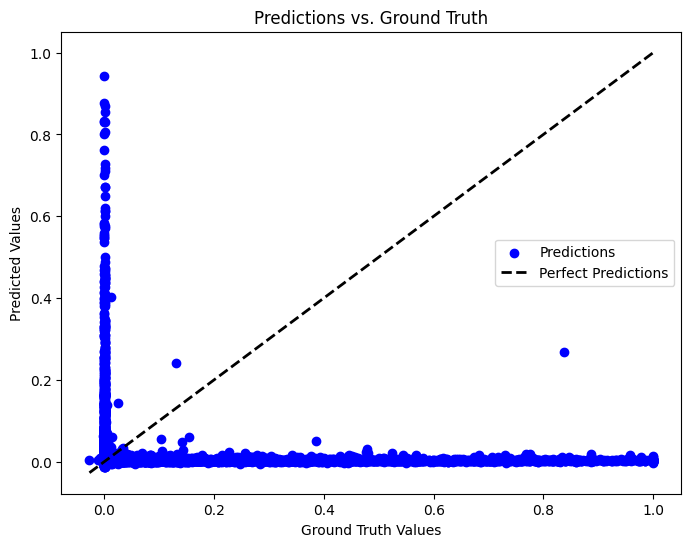

In [11]:
import matplotlib.pyplot as plt

y_true = lengths_with_score['target_scores']
y_pred = lengths_with_score['prediction']

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, color='blue', label='Predictions')
plt.title('Predictions vs. Ground Truth')
plt.xlabel('Ground Truth Values')
plt.ylabel('Predicted Values')

# Plotting the perfect predictions line
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, label='Perfect Predictions')

plt.legend()
plt.show()